Matriz de autocorrelação R_x:
[[1.0004 1.1   ]
 [1.1    0.0218]]

Vetor de correlação cruzada p_xd:
[0.21611482725338546, 0.018648385650874878, -0.0030948528901104297, -0.013467368603694406, 0.005920852987717112, 0.005403564093077553]

Soluções de Wiener:
[array([0.196109 , 0.0181158]), array([0.0169221, 0.0015632]), array([-0.00280836, -0.00025943]), array([-0.01222069, -0.0011289 ]), array([0.00537276, 0.00049631]), array([0.00490335, 0.00045295])]

Erros residuais:
[1.0097219730667009, 0.9933362451627082, 1.0012430071999336, 1.0056936006988824, 0.9977307256420057, 0.9979232909951362]


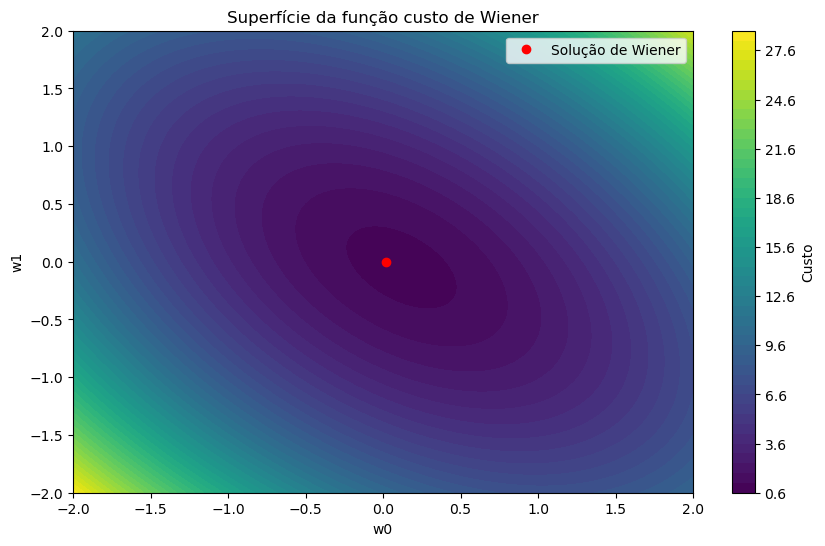

TypeError: stem() got an unexpected keyword argument 'use_line_collection'

<Figure size 640x480 with 0 Axes>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

# Definindo parâmetros
H = np.array([0.2, 0.7, 1.3])  # Resposta ao impulso do canal
sigma_n = 0.01  # Variância do ruído
num_samples = 10000  # Número de amostras

# Gerando sinal s(n)
np.random.seed(0)  # Para reprodutibilidade
s = np.random.choice([-1, 1], size=num_samples)

# Filtrando pelo canal
x = lfilter(H, 1, s) + np.random.normal(0, np.sqrt(sigma_n), num_samples)

# a) Matriz de autocorrelação R_x de ordem 2
R_x = np.zeros((2, 2))
R_x[0, 0] = 1 + 0.01 * (H[0] ** 2)  # R_x(0)
R_x[0, 1] = 0.7 + 0.2 * 0.7 + 1.3 * 0.2  # R_x(1)
R_x[1, 0] = R_x[0, 1]
R_x[1, 1] = 0.01 * (H[1] ** 2 + H[2] ** 2)  # R_x(2)

print("Matriz de autocorrelação R_x:")
print(R_x)

# b) Vetor de correlação cruzada p_xd
p_xd = []
for delay in range(6):
    d = np.roll(s, -delay)  # d(n) = s(n-delay)
    pxd = np.correlate(x, d, mode='valid') / num_samples  # Normalização pela quantidade de amostras
    p_xd.append(pxd[0])  # Apenas o primeiro elemento é relevante

print("\nVetor de correlação cruzada p_xd:")
print(p_xd)

# c) Soluções de Wiener
errors = []
wiener_solutions = []
for delay in range(6):
    R_xd = R_x[:2, :2]  # Matriz de autocorrelação (2x2)
    pxd = np.array([p_xd[delay], p_xd[delay]])  # Vetor de correlação cruzada
    w = np.linalg.inv(R_x).dot(pxd)  # Solução de Wiener
    wiener_solutions.append(w)
    y_hat = np.convolve(x, w, mode='same')  # Saída do filtro
    error = np.mean((s - y_hat) ** 2)  # Erro quadrático médio
    errors.append(error)

print("\nSoluções de Wiener:")
print(wiener_solutions)
print("\nErros residuais:")
print(errors)

# d) Superfície da função custo de Wiener
best_delay = np.argmin(errors)
w_optimal = wiener_solutions[best_delay]
error_min = errors[best_delay]

# Criar grade de valores para visualizar a função custo
w0_range = np.linspace(-2, 2, 100)
w1_range = np.linspace(-2, 2, 100)
cost_surface = np.zeros((len(w0_range), len(w1_range)))

for i, w0 in enumerate(w0_range):
    for j, w1 in enumerate(w1_range):
        y_hat = np.convolve(x, [w0, w1], mode='same')
        cost_surface[i, j] = np.mean((s - y_hat) ** 2)

# Plotar a superfície da função custo
W0, W1 = np.meshgrid(w0_range, w1_range)
plt.figure(figsize=(10, 6))
plt.contourf(W0, W1, cost_surface.T, levels=50, cmap='viridis')
plt.colorbar(label='Custo')
plt.plot(w_optimal[0], w_optimal[1], 'ro', label='Solução de Wiener')
plt.title('Superfície da função custo de Wiener')
plt.xlabel('w0')
plt.ylabel('w1')
plt.legend()
plt.show()

# e) Respostas combinadas canal-equalizador
for delay in range(4):
    combined_response = np.convolve(H, wiener_solutions[delay])
    plt.figure()
    plt.stem(combined_response, use_line_collection=True)
    plt.title(f'Resposta combinada Canal-equalizador para atraso {delay}')
    plt.xlabel('Amostras')
    plt.ylabel('Amplitude')
    plt.grid()
    plt.show()
